In [1]:
import numpy as np
import pandas as pd
import scipy.signal

from scipy import misc
from numpy import linalg as LA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import avgn_attack
from utils import convolve2D
from utils import (
    forward_differences_second,
    backward_differences,
    forward_differences
    
)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
X = X.to_numpy()
y = y.to_numpy()
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


In [4]:
X_train.shape

(33600, 784)

In [5]:
sample = X_train[0, :].reshape(-1, 1) / 255
sample = sample.reshape(28, 28)

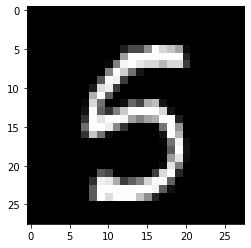

In [6]:
plt.imshow(sample, "gray")
plt.show()

In [7]:
noisy_sample = avgn_attack(sample, std=0.3, mean=0)

#image_filter = 1/25.* np.ones([5, 5])
#noisy_sample = scipy.signal.convolve2d(noisy_sample, image_filter)

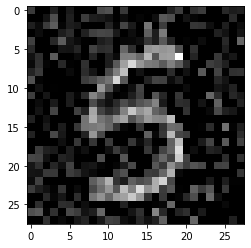

In [8]:
plt.imshow(noisy_sample, "gray")
plt.show()

In [9]:
import numpy as np
from scipy import optimize
from scipy import misc

# Original implementation
# https://github.com/danoan/image-processing/blob/master/denoise.py

class TotalGradient:
    def __init__(self, image):
        fd = forward_differences(image)
        self.gradX = fd[0]
        self.gradY = fd[1]

        fd2 = forward_differences_second(image)
        self.grad2X = fd2[0]
        self.grad2Y = fd2[1]

    def norm(self):
        return self.gradX**2 + self.gradY**2

class Tikhonov:
    def __init__(self, image, alpha):
        self.image = image
        self.alpha = alpha

        self.shape = self.image.shape
        self.size = self.image.size

    def jacobian(self, x):
        _x = x.reshape(self.shape)
        TG = TotalGradient(_x)

        S = self.alpha * (TG.grad2X + TG.grad2Y)
        return (_x - self.image - S).reshape(self.size,)

    def tikhonov(self, x):
        _x = x.reshape( self.shape )
        TG = TotalGradient(_x)

        # arg min_x || A(x) - y ||^2 + r(x)
        # r(x) - log prior
        # y - noisy image
        # A(x) - reconstructed image        
        v = 0.5*(LA.norm(_x - self.image)**2 + self.alpha*np.sum(TG.norm()))
        return v

def denoise_image(input_image, alpha, max_it, print_output=False):
    T = Tikhonov(input_image, alpha)
    solution = optimize.minimize(
        lambda x: T.tikhonov(x),
        np.zeros(T.image.size,),
        jac=lambda x: T.jacobian(x),
        method="CG",
        options={
            "maxiter":max_it, 
            "disp":print_output
        }
    )

    x = solution["x"].reshape(T.shape)
    return x

In [10]:
denoised_sample = denoise_image(noisy_sample, 0.7, 100, print_output=True)

print("Original to denoised norm: ", LA.norm(sample - denoised_sample))
print("Original to noised norm: ", LA.norm(sample - noisy_sample))

         Current function value: 18.212919
         Iterations: 8
         Function evaluations: 81
         Gradient evaluations: 69
Original to denoised norm:  5.41451523610961
Original to noised norm:  6.51241023297815


#### Noisy image

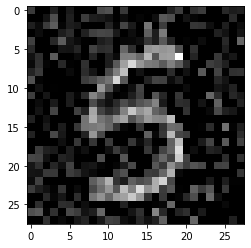

In [11]:
plt.imshow(noisy_sample, 'gray')

#### Denoised image

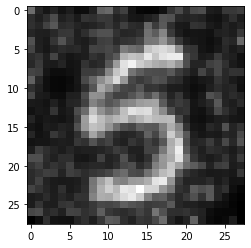

In [12]:
plt.imshow(denoised_sample, 'gray')